# Project to predict the popularity of Political leaders and detect hate speech and tribalism from Facebook and Twitter comments

## Imports

In [96]:
from webdriver_manager.chrome import ChromeDriverManager

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import StaleElementReferenceException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait

from bs4 import BeautifulSoup

import pandas as pd

import time

# for tweets collection
import tweepy

# text cleaning
import preprocessor as p

# text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet

#lemmatization
from nltk.stem import WordNetLemmatizer

#sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag

## visualization
import matplotlib.pyplot as plt
%matplotlib inline

# get the language of the text
import langdetect
#for ner recognition
import spacy

from langdetect.lang_detect_exception import LangDetectException

#Hatespeech imports
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#to data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#NLP tools
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#train split and fit models
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
  
#model selection
from sklearn.metrics import confusion_matrix, accuracy_score


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip uninstall preprocessor

^C


# GET FACEBOOK COMMENTS

In [97]:
# scroll down
def scroll():
    pop_out_btn = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "popup_xout")))
    pop_out_btn.click()

In [98]:
# funtion to click the view more button
def view_more_click(driver):
    try: 
        view_more_comments = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, "View more comments…")))
        view_more_comments.click()
    
    except TimeoutException:
        view_more_comments = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.LINK_TEXT, "View previous comments…")))
        view_more_comments.click()
        
    except ElementClickInterceptedException:
        scroll()
    
    except (NoSuchElementException,ElementClickInterceptedException, StaleElementReferenceException) as es :
        print(es)
    html = driver.page_source
    return html

# function to click the button 50 times
def view_more_comm(driver):
    i = 0
    while i < 50:
        html = view_more_click(driver)
        time.sleep(3)
        i += 1
    return html

In [99]:
# function to get a list of all the comment elements
def get_comments(html):
    soup = BeautifulSoup(html, 'html.parser')
    comment_section = soup.find("div", {"class":"_59e9 _1-ut _2a_g _34oh" })
    comment_els = comment_section.find_all("div", {"class":"_2a_i"})
    
    master_list = []
    for c in comment_els:
        data_dict = {}
        data_dict["User"] = c.find("div", {"class":"_2b05"}).text
        data_dict["Comment"] = c.find("div", {"data-sigil":"comment-body"}).text
        master_list.append(data_dict)
    return master_list

    
    

# GETTING TWITTER DATA

## Twitter Authentication

In [100]:
# read the keys from the file 
def authorize_twitter():
    keys = []
    with open('../Keys.txt') as f:
        for line in f:
            keys.append(line.strip())

    API_KEY = keys[1]
    API_KEY_SECRET = keys [4]
    ACCESS_TOKEN = keys[10]
    ACCESS_TOKEN_SECRET = keys[13]
    
    # initialize the api
    auth = tweepy.OAuthHandler(API_KEY, API_KEY_SECRET)
    auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
    api = tweepy.API(auth)
    
    return (api)

## Get the replies from the posts

In [101]:
def get_replies(url):
    name = url.split("/")[-3]
    tweet_id = url.split("/")[-1]

    #empty list for the replies
    replies = []
    
    api = authorize_twitter()
    # get replies from the tweet
    for tweet in tweepy.Cursor(api.search_tweets,q='to:'+name, result_type='recent').items(1000):
        if hasattr(tweet, 'in_reply_to_status_id_str'):
            if (tweet.in_reply_to_status_id_str==tweet_id):
                replies.append(tweet)
    
    #master list to hold all the data needed
    master_list = []
    for reply in replies:
        data_dict = {}
        data_dict["User"] = reply.author.screen_name
        data_dict["Comment"] = reply.text

        master_list.append(data_dict)
        
    return (master_list)

# TEXT PREPROCESSING

## Tokenization and POS tagging + removing stop words

In [102]:
#perform tokenization and pos tagging and remove stop words
pos_dict = {'J': wordnet.ADJ, 'v': wordnet.VERB, 'N': wordnet.NOUN, 'R': wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    newlist = []
    
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
            newlist.append(tuple([word, pos_dict.get(tag[0])]))
            
    return newlist

## Lemmatization

In [103]:
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
        if not pos:
            lemma = word
            lemma_rew = lemma_rew + " " + lemma
        else:
            lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
            lemma_rew = lemma_rew + " " + lemma
    return lemma_rew


## Language detection

In [104]:
def get_language(text):
    try:
        lang = langdetect.detect(text)
        
        return lang
    except LangDetectException:
        print(text, "is invalid")

## SENTIMENT ANALYSIS USING VADER

In [105]:
def vaderSentimentAnalysis(text):
    analyzer = SentimentIntensityAnalyzer()
    vs= analyzer.polarity_scores(text)
    return vs['compound']

# function to analyse 
def vader_analysis(compound):
    if compound > 0:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'

## Get names and parties from the text

In [232]:
def get_parties(text):
    parties="None"
    for i in range(len(text)):
        tags = text[i][1]
        if tags == "POLITICAL_PARTY":
            party = text[i][0]
            if party not in parties:
                parties=party
        else:
            continue
        return parties

In [234]:
def get_names(text):
    names="None"
    for i in range(len(text)):
        tags = text[i][1]
        if tags == "POLITICIAN":
            name = text[i][0]
            names=name
            break
        else:
            return "None"
            continue
    return names

# MAIN FILE

In [109]:

choice = input("Please select the choice of your data. \n 1. for facebook. \n 2. For twitter")
if choice == "1":
    # install webdriver
    driver = webdriver.Chrome(ChromeDriverManager().install())
    url = input("Paste the Facebook mobile url: ")
    driver.get(url)

    print("Getting comments please wait...\n")
    html = view_more_comm(driver)

    master_list = get_comments(html)

    print(str(len(master_list)) + " Comments found")
        
else:
    url = input("Paste the tweet url: ")
    print("----Getting replies please wait------")
    master_list = get_replies(url)
    print(str(len(master_list)) + " Comments found") 


Please select the choice of your data. 
 1. for facebook. 
 2. For twitter 1




====== WebDriver manager ======
Current google-chrome version is 99.0.4844
Get LATEST chromedriver version for 99.0.4844 google-chrome
Driver [C:\Users\User\.wdm\drivers\chromedriver\win32\99.0.4844.51\chromedriver.exe] found in cache
<ipython-input-109-f1926d5477a2>:4: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())


Paste the Facebook mobile url:  https://mobile.facebook.com/story.php?story_fbid=10160057057749430&id=88201339429&m_entstream_source=timeline


Getting comments please wait...

485 Comments found


In [195]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))
def clean_text(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = [word for word in text.split(' ') if word not in stopword]
    text=" ".join(text)
    text = [stemmer.stem(word) for word in text.split(' ')]
    text=" ".join(text)
    return text

In [196]:
    #create a dataframe and clean the text
df = pd.DataFrame(master_list)
df["clean_tweets"] = df["Comment"].apply(lambda x: clean_text(x))
df

,User,Comment,clean_tweets
0,Gerald Ngaruchi,every presidential aspirant must play the role...,everi presidenti aspir must play role oppositi...
1,Maina Mugambi,DP cannot and should not be dramatize opposit...,dp cannot dramat opposit enjoy state largese...
2,Annet Masinde,"He needs to be in opposition, doing a good job...",he need opposit good job oversight
3,Kiprono Mutahi,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward acc...
4,Julius Murithi,Should he continue drawing a salary from publi...,should continu draw salari public coffer
...,...,...,...
480,Sam Didane,Githeri media,githeri media
481,Awuor Nyocholla,You possess what you proclaim,you possess proclaim
482,Honesty Wegeza,Zoe,zoe
483,Musala Sitati,Give us dates and new salary you draw,give us date new salari draw


## Text Preprocessing

In [197]:
nltk.download('averaged_perceptron_tagger')
df['POS tagged'] = df['clean_tweets'].apply(lambda x: token_stop_pos(x))
df

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,User,Comment,clean_tweets,POS tagged
0,Gerald Ngaruchi,every presidential aspirant must play the role...,everi presidenti aspir must play role oppositi...,"[(everi, n), (presidenti, n), (aspir, n), (mus..."
1,Maina Mugambi,DP cannot and should not be dramatize opposit...,dp cannot dramat opposit enjoy state largese...,"[(dp, n), (dramat, None), (opposit, n), (enjoy..."
2,Annet Masinde,"He needs to be in opposition, doing a good job...",he need opposit good job oversight,"[(need, None), (opposit, None), (good, a), (jo..."
3,Kiprono Mutahi,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward acc...,"[(may, None), (almighti, None), (god, n), (ans..."
4,Julius Murithi,Should he continue drawing a salary from publi...,should continu draw salari public coffer,"[(continu, None), (draw, None), (salari, a), (..."
...,...,...,...,...
480,Sam Didane,Githeri media,githeri media,"[(githeri, n), (media, n)]"
481,Awuor Nyocholla,You possess what you proclaim,you possess proclaim,"[(possess, None), (proclaim, None)]"
482,Honesty Wegeza,Zoe,zoe,"[(zoe, n)]"
483,Musala Sitati,Give us dates and new salary you draw,give us date new salari draw,"[(give, None), (us, None), (date, n), (new, a)..."


In [198]:
# Lemmatization
df['Lemma'] = df['POS tagged'].apply(lambda x: lemmatize(x))
df.head()

,User,Comment,clean_tweets,POS tagged,Lemma
0,Gerald Ngaruchi,every presidential aspirant must play the role...,everi presidenti aspir must play role oppositi...,"[(everi, n), (presidenti, n), (aspir, n), (mus...",everi presidenti aspir must play role opposi...
1,Maina Mugambi,DP cannot and should not be dramatize opposit...,dp cannot dramat opposit enjoy state largese...,"[(dp, n), (dramat, None), (opposit, n), (enjoy...",dp dramat opposit enjoy state largese resign...
2,Annet Masinde,"He needs to be in opposition, doing a good job...",he need opposit good job oversight,"[(need, None), (opposit, None), (good, a), (jo...",need opposit good job oversight
3,Kiprono Mutahi,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward acc...,"[(may, None), (almighti, None), (god, n), (ans...",may almighti god answer prayer wish reward a...
4,Julius Murithi,Should he continue drawing a salary from publi...,should continu draw salari public coffer,"[(continu, None), (draw, None), (salari, a), (...",continu draw salari public coffer


## Get only english text

In [199]:
df['language'] = df['clean_tweets'].apply(lambda x: get_language(x) if x.strip()!="" else "")
df = df[df['language']=='en'].reset_index(drop=True)
df.drop('language', axis=1)
df

😂😂😂😂 is invalid
😂😅😅😅😅 is invalid
🤣🤣 is invalid
🤣🤣🤣🤣🤣 is invalid
😂😂😂😂 is invalid
😂😂😂😂😂 is invalid


,User,Comment,clean_tweets,POS tagged,Lemma,language
0,Gerald Ngaruchi,every presidential aspirant must play the role...,everi presidenti aspir must play role oppositi...,"[(everi, n), (presidenti, n), (aspir, n), (mus...",everi presidenti aspir must play role opposi...,en
1,Maina Mugambi,DP cannot and should not be dramatize opposit...,dp cannot dramat opposit enjoy state largese...,"[(dp, n), (dramat, None), (opposit, n), (enjoy...",dp dramat opposit enjoy state largese resign...,en
2,Annet Masinde,"He needs to be in opposition, doing a good job...",he need opposit good job oversight,"[(need, None), (opposit, None), (good, a), (jo...",need opposit good job oversight,en
3,Kiprono Mutahi,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward acc...,"[(may, None), (almighti, None), (god, n), (ans...",may almighti god answer prayer wish reward a...,en
4,Julius Murithi,Should he continue drawing a salary from publi...,should continu draw salari public coffer,"[(continu, None), (draw, None), (salari, a), (...",continu draw salari public coffer,en
...,...,...,...,...,...,...
232,Marsden Bundi,"Resign first,",resign first,"[(resign, n), (first, r)]",resign first,en
233,Begi Moraah,Wooow our deputy 😂,wooow deputi 😂,"[(wooow, n), (deputi, n), (😂, n)]",wooow deputi 😂,en
234,Faith Isaack,We don't care,we dont care,"[(dont, None), (care, None)]",dont care,en
235,Jeff Kosgei,Githeri media,githeri media,"[(githeri, n), (media, n)]",githeri medium,en


## Geta clean dataframe for text analysis

In [200]:
fin_data= pd.DataFrame(df[['Comment', 'Lemma']])

## Sentiment Analysis

In [201]:
fin_data['Vader_Sentiment'] = fin_data['Comment'].apply(lambda x: vaderSentimentAnalysis(x))
fin_data['Vader_Analysis'] = fin_data['Vader_Sentiment'].apply(lambda x: vader_analysis(x))
fin_data[1:50]

,Comment,Lemma,Vader_Sentiment,Vader_Analysis
1,DP cannot and should not be dramatize opposit...,dp dramat opposit enjoy state largese resign...,0.4653,Positive
2,"He needs to be in opposition, doing a good job...",need opposit good job oversight,0.4404,Positive
3,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward a...,0.7506,Positive
4,Should he continue drawing a salary from publi...,continu draw salari public coffer,0.0000,Neutral
5,He drove himself to the opposition a term ahea...,drove opposit term ahead rehears still under...,-0.5499,Negative
6,I would have taken you seriously if you just s...,would taken serious stop earn money reject e...,0.5574,Positive
7,And you will remain as such for the next 10yrs...,remain next youv start well keep mr six mont...,0.8870,Positive
8,With tremendous respect the DP should resign a...,tremend respect dp resign statesman great le...,0.4927,Positive
9,May your wish to remain in opposition come tru...,may wish remain opposit come true august 😏,0.6705,Positive
10,Gap well filled congratulations 👏👏👏 opposition...,gap well fill congratul 👏👏👏 opposit leader w...,0.7783,Positive


In [202]:
vd_counts = fin_data["Vader_Analysis"].value_counts()
vd_counts

Positive    116
Neutral      77
Negative     44
Name: Vader_Analysis, dtype: int64

## Named Entity Recognition

In [203]:
nlp = spacy.load("political_ner_model")
fin_data["tags"] = df["Comment"].apply(lambda x: [(tag.text, tag.label_) for tag in nlp(x).ents])
fin_data[1:50]

,Comment,Lemma,Vader_Sentiment,Vader_Analysis,tags
1,DP cannot and should not be dramatize opposit...,dp dramat opposit enjoy state largese resign...,0.4653,Positive,"[(DP, POLITICAL_PARTY)]"
2,"He needs to be in opposition, doing a good job...",need opposit good job oversight,0.4404,Positive,[]
3,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward a...,0.7506,Positive,"[(Mr., POLITICIAN)]"
4,Should he continue drawing a salary from publi...,continu draw salari public coffer,0.0000,Neutral,[]
5,He drove himself to the opposition a term ahea...,drove opposit term ahead rehears still under...,-0.5499,Negative,[]
6,I would have taken you seriously if you just s...,would taken serious stop earn money reject e...,0.5574,Positive,[]
7,And you will remain as such for the next 10yrs...,remain next youv start well keep mr six mont...,0.8870,Positive,"[(Mr., POLITICIAN)]"
8,With tremendous respect the DP should resign a...,tremend respect dp resign statesman great le...,0.4927,Positive,"[(DP, POLITICIAN)]"
9,May your wish to remain in opposition come tru...,may wish remain opposit come true august 😏,0.6705,Positive,"[(😏, POLITICIAN)]"
10,Gap well filled congratulations 👏👏👏 opposition...,gap well fill congratul 👏👏👏 opposit leader w...,0.7783,Positive,[]


## Get names and political parties

In [236]:
fin_data["Parties"] = fin_data["tags"].apply(lambda x: get_parties(x))
fin_data["Politicians"] = fin_data["tags"].apply(lambda x: get_names(x))
fin_data.head()

,Comment,Lemma,Vader_Sentiment,Vader_Analysis,tags,Parties,Politicians,Hatespeech Category
0,every presidential aspirant must play the role...,everi presidenti aspir must play role opposi...,0.6084,Positive,"[(Ruto, POLITICIAN), (4, POLITICIAN), (Ruto, P...",None,Ruto,not hateful
1,DP cannot and should not be dramatize opposit...,dp dramat opposit enjoy state largese resign...,0.4653,Positive,"[(DP, POLITICAL_PARTY)]",DP,None,not hateful
2,"He needs to be in opposition, doing a good job...",need opposit good job oversight,0.4404,Positive,[],None,None,not hateful
3,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward a...,0.7506,Positive,"[(Mr., POLITICIAN)]",None,Mr.,not hateful
4,Should he continue drawing a salary from publi...,continu draw salari public coffer,0.0000,Neutral,[],None,None,not hateful


In [205]:
## Get names and political parties

In [206]:
import os
#to get the current working directory
directory = os.getcwd()
print(directory)
#Importing the dataset
dataset = pd.read_csv(directory +'\data_sets\\hate-speech-and-offensive-language-dataset\\labeled_data.csv')
dataset.info()
ke_dataset = pd.read_csv(directory +'\data_sets\\hate-speech-kenya\\HateSpeechKEN.csv')
data_train = pd.read_csv(directory +'\data_sets\\twitter-sentiment-analysis-hatred-speech\\train.csv')

C:\Users\User\python_projects\scripty
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [207]:
dataset.drop(['Unnamed: 0','count','hate_speech','offensive_language','neither'],axis=1,inplace=True)
ke_dataset.drop(['count','hate_speech','offensive_language','neither'],axis=1,inplace=True)
data_train.drop('id', axis=1,inplace=True)

In [208]:
dataset["class"].replace({0: 1}, inplace=True)
ke_dataset["class"].replace({0: 1}, inplace=True)

In [209]:
dataset["class"].replace({2: 0}, inplace=True)
ke_dataset["class"].replace({2: 0}, inplace=True)
dataset.rename(columns ={'class':'label'}, inplace = True)
ke_dataset.rename(columns ={'class':'label'}, inplace = True)

In [210]:
frame=[data_train,dataset,ke_dataset[25500::]]
df = pd.concat(frame)
df.head(5)

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation


In [211]:
df['tweet']=df['tweet'].apply(clean_text)
df.head()
df.shape

(81420, 2)

In [212]:
X = df['tweet']
y = df['label']

In [213]:
#splitting the dataset into Trainign and testing data set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [214]:
count = CountVectorizer(stop_words='english', ngram_range=(1,5),max_features=2000)
x_train_vectorizer=count.fit_transform(X_train)
x_test_vectorizer=count.transform(X_test)
x_train_vectorizer.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [215]:
#
tfidf = TfidfTransformer()

x_train_tfidf = tfidf.fit_transform(x_train_vectorizer)

x_train_tfidf.toarray()
x_test_tfidf = tfidf.transform(x_test_vectorizer)

In [216]:
#using Naive Bayes model
classifier_np = MultinomialNB()
classifier_np.fit(x_train_vectorizer, y_train)

MultinomialNB()

In [217]:
#Naive Bayes
y_pred_np = classifier_np.predict(x_test_vectorizer)
cm = confusion_matrix(y_test, y_pred_np)
print(cm)

[[9351 2157]
 [1055 7792]]


In [218]:
#Accuracy of the naive bayes prediction model.
np_score = accuracy_score(y_test, y_pred_np)

print('Naive Bayes Accuracy: ', str(np_score))

Naive Bayes Accuracy:  0.8422009334315893


In [219]:
def detect_hatespeech(text):
    text=[clean_text(text)]
    text_vectorizer=count.transform(text)
    test_tfidf = tfidf.transform(text_vectorizer)
    prediction=classifier_np.predict(test_tfidf)
    category="none"
    if prediction[0]==0:
        category="not hateful"
    else:
        category="hateful and offensive"
    return category
    

In [237]:
fin_data['Hatespeech Category']=fin_data['Comment'].apply(lambda x:detect_hatespeech(x))
fin_data.head(5)

,Comment,Lemma,Vader_Sentiment,Vader_Analysis,tags,Parties,Politicians,Hatespeech Category
0,every presidential aspirant must play the role...,everi presidenti aspir must play role opposi...,0.6084,Positive,"[(Ruto, POLITICIAN), (4, POLITICIAN), (Ruto, P...",None,Ruto,not hateful
1,DP cannot and should not be dramatize opposit...,dp dramat opposit enjoy state largese resign...,0.4653,Positive,"[(DP, POLITICAL_PARTY)]",DP,None,not hateful
2,"He needs to be in opposition, doing a good job...",need opposit good job oversight,0.4404,Positive,[],None,None,not hateful
3,May our Almighty God answer your prayer wishes...,may almighti god answer prayer wish reward a...,0.7506,Positive,"[(Mr., POLITICIAN)]",None,Mr.,not hateful
4,Should he continue drawing a salary from publi...,continu draw salari public coffer,0.0000,Neutral,[],None,None,not hateful


In [243]:
#All politicians.
fin_data.loc[(fin_data['Politicians']!="None")].count()

Comment                44
Lemma                  44
Vader_Sentiment        44
Vader_Analysis         44
tags                   44
Parties                 2
Politicians            44
Hatespeech Category    44
dtype: int64

In [259]:
def political_influence(political_name):
    count=0
    Raila=["Raila Amolo Odinga","Raila", "Amolo","Odinga",
            "raila amolo odinga",
            "Baba","baba",
            "Rao","rao",
            "Kitendawili","kitendawili"
          ]
    Uhuru=[ "Uhuru Muigai Kenyatta","Uhuru", "Muigai","Kenyatta",
            "uhuru muigai kenyatta",
            "Number one","number one",
            "Uhunye","uhunye",
            "Jayden","jayden"
          ]
    Ruto =[ "William Samoei Ruto","william samoei ruto",
            "William","Samoie","Ruto",
            "Willie","willie",
            "Deputy President","deputy president",
            "DP","dP",
            "Wheelbarrow","wheelbarrow",
            "Bwana Mashamba","bwana mashamba",
            "WSR","wsr"
          ]
    if political_name=="Raila":
        for i in Raila:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)])
    elif political_name=="Ruto":
        for i in Ruto:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)])
    elif political_name=="Uhuru":
        for i in Uhuru:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)])
    return count
    

In [303]:
political_influence("Ruto")

17

In [288]:
import matplotlib.pyplot as plt
import numpy as np
def political_analysis_plot(politician1,politician2):
    n=politician1
    m=politician2
    a=political_influence(n)
    b=political_influence(m)
    y = np.array([a,b])
    mylabels = [n, m]
    myexplode = [0.1, 0]
    C1="red"
    c2="blue"
    if n=="Ruto":
        c1="yellow"
    elif n=="Raila":
        c1="blue"
    elif n=="Uhuru":
        c1="orange"
    if m=="Ruto":
        c2="yellow"
    elif m=="Raila":
        c2="blue"
    elif m=="Uhuru":
        c2="red"   
    Colors=[c1,c2]   

    fig, ax = plt.subplots(figsize = (10,6))
    ax.grid(False)
    plt.style.use('ggplot')

    plt.pie(y, labels = mylabels, explode = myexplode,colors=Colors, shadow = True, autopct='%1.0f%%')
    plt.legend()
    fig.set_facecolor('lightgrey')
    plt.title("Total Political Reactions")
    plt.show() 

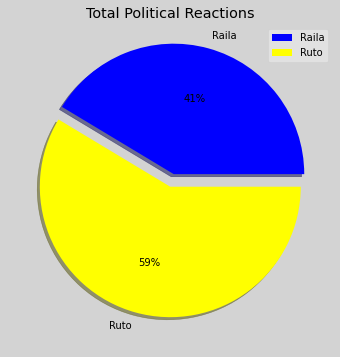

In [291]:
political_analysis_plot("Raila","Ruto")

In [307]:
def positive_political_sentiment_analysis(political_name):
    count=0
    Raila=["Raila Amolo Odinga","Raila", "Amolo","Odinga",
            "raila amolo odinga",
            "Baba","baba",
            "Rao","rao",
            "Kitendawili","kitendawili"
          ]
    Uhuru=[ "Uhuru Muigai Kenyatta","Uhuru", "Muigai","Kenyatta",
            "uhuru muigai kenyatta",
            "Number one","number one",
            "Uhunye","uhunye",
            "Jayden","jayden"
          ]
    Ruto =[ "William Samoei Ruto","william samoei ruto",
            "William","Samoie","Ruto",
            "Willie","willie",
            "Deputy President","deputy president",
            "DP","dP",
            "Wheelbarrow","wheelbarrow",
            "Bwana Mashamba","bwana mashamba",
            "WSR","wsr"
          ]
    if political_name=="Raila":
        for i in Raila:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Positive")])
            
    elif political_name=="Ruto":
        for i in Ruto:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Positive")])
           
    elif political_name=="Uhuru":
        for i in Uhuru:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Positive")])
            
    return count
    

In [308]:
positive_political_sentiment_analysis("Ruto")

10

In [309]:
def negative_political_sentiment_analysis(political_name):
    count=0
    Raila=["Raila Amolo Odinga","Raila", "Amolo","Odinga",
            "raila amolo odinga",
            "Baba","baba",
            "Rao","rao",
            "Kitendawili","kitendawili"
          ]
    Uhuru=[ "Uhuru Muigai Kenyatta","Uhuru", "Muigai","Kenyatta",
            "uhuru muigai kenyatta",
            "Number one","number one",
            "Uhunye","uhunye",
            "Jayden","jayden"
          ]
    Ruto =[ "William Samoei Ruto","william samoei ruto",
            "William","Samoie","Ruto",
            "Willie","willie",
            "Deputy President","deputy president",
            "DP","dP",
            "Wheelbarrow","wheelbarrow",
            "Bwana Mashamba","bwana mashamba",
            "WSR","wsr"
          ]
    if political_name=="Raila":
        for i in Raila:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Negative")])
    elif political_name=="Ruto":
        for i in Ruto:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Negative")])
    elif political_name=="Uhuru":
        for i in Uhuru:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Negative")])
    return count
    

In [313]:
negative_political_sentiment_analysis("Ruto")

1

In [315]:
def neutral_political_sentiment_analysis(political_name):
    count=0
    Raila=["Raila Amolo Odinga","Raila", "Amolo","Odinga",
            "raila amolo odinga",
            "Baba","baba",
            "Rao","rao",
            "Kitendawili","kitendawili"
          ]
    Uhuru=[ "Uhuru Muigai Kenyatta","Uhuru", "Muigai","Kenyatta",
            "uhuru muigai kenyatta",
            "Number one","number one",
            "Uhunye","uhunye",
            "Jayden","jayden"
          ]
    Ruto =[ "William Samoei Ruto","william samoei ruto",
            "William","Samoie","Ruto",
            "Willie","willie",
            "Deputy President","deputy president",
            "DP","dP",
            "Wheelbarrow","wheelbarrow",
            "Bwana Mashamba","bwana mashamba",
            "WSR","wsr"
          ]
    if political_name=="Raila":
        for i in Raila:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Neutral")])
    elif political_name=="Ruto":
        for i in Ruto:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Neutral")])
    elif political_name=="Uhuru":
        for i in Uhuru:
            count+=len(fin_data.loc[(fin_data['Politicians']==i)&(fin_data['Vader_Analysis']=="Neutral")])
    return count
    

In [317]:
neutral_political_sentiment_analysis("Ruto")

6

In [318]:
def positive_sentiment_plot(politician1,politician2):
    n=politician1
    m=politician2
    a=positive_political_sentiment_analysis(n)
    b=positive_political_sentiment_analysis(m)
    y = np.array([a,b])
    mylabels = [n, m]
    myexplode = [0.1, 0]
    C1="red"
    c2="blue"
    if n=="Ruto":
        c1="yellow"
    elif n=="Raila":
        c1="blue"
    elif n=="Uhuru":
        c1="orange"
    if m=="Ruto":
        c2="yellow"
    elif m=="Raila":
        c2="blue"
    elif m=="Uhuru":
        c2="red"   
    Colors=[c1,c2]   

    fig, ax = plt.subplots(figsize = (10,6))
    ax.grid(False)
    plt.style.use('ggplot')

    plt.pie(y, labels = mylabels, explode = myexplode,colors=Colors, shadow = True, autopct='%1.0f%%')
    plt.legend()
    fig.set_facecolor('white')
    plt.title("Positive Political Sentiment Analysis")
    plt.show() 

In [323]:
def negative_sentiment_plot(politician1,politician2):
    n=politician1
    m=politician2
    a=negative_political_sentiment_analysis(n)
    b=negative_political_sentiment_analysis(m)
    y = np.array([a,b])
    mylabels = [n, m]
    myexplode = [0.1, 0]
    C1="red"
    c2="blue"
    if n=="Ruto":
        c1="yellow"
    elif n=="Raila":
        c1="blue"
    elif n=="Uhuru":
        c1="orange"
    if m=="Ruto":
        c2="yellow"
    elif m=="Raila":
        c2="blue"
    elif m=="Uhuru":
        c2="red"   
    Colors=[c1,c2]   

    fig, ax = plt.subplots(figsize = (10,6))
    ax.grid(False)
    plt.style.use('ggplot')

    plt.pie(y, labels = mylabels, explode = myexplode,colors=Colors, shadow = True, autopct='%1.0f%%')
    plt.legend()
    fig.set_facecolor('white')
    plt.title("Negative Political Sentiment Analysis")
    plt.show() 

In [342]:
def neutral_sentiment_plot(politician1,politician2):
    n=politician1
    m=politician2
    a=neutral_political_sentiment_analysis(n)
    b=neutral_political_sentiment_analysis(m)
    y = np.array([a,b])
    mylabels = [n, m]
    myexplode = [0.1, 0]
    C1="red"
    c2="blue"
    if n=="Ruto":
        c1="yellow"
    elif n=="Raila":
        c1="blue"
    elif n=="Uhuru":
        c1="orange"
    if m=="Ruto":
        c2="yellow"
    elif m=="Raila":
        c2="blue"
    elif m=="Uhuru":
        c2="red"   
    Colors=[c1,c2]   

    fig, ax = plt.subplots(figsize = (10,6))
    ax.grid(False)
    plt.style.use('ggplot')

    plt.pie(y, labels = mylabels, explode = myexplode,colors=Colors, shadow = True, autopct='%1.0f%%')
    plt.legend()
    fig.set_facecolor('white')
    plt.title("Neutral Political Sentiment Analysis")
    plt.show() 

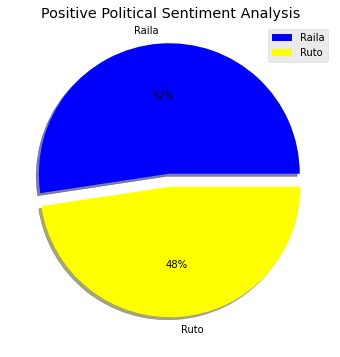

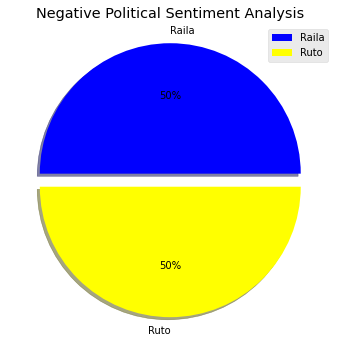

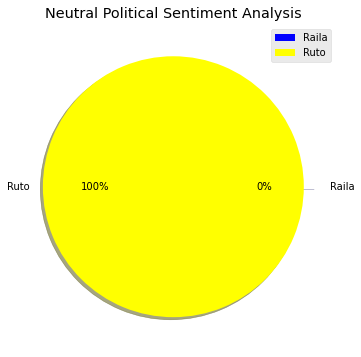

In [343]:
positive_sentiment_plot("Raila","Ruto")
negative_sentiment_plot("Raila","Ruto")
neutral_sentiment_plot("Raila","Ruto")

In [355]:
def Hate_speech_and_offensive_language_analysis():
    h=len(fin_data.loc[(fin_data['Hatespeech Category']=="hateful and offensive")])
    nh=len(fin_data.loc[(fin_data['Hatespeech Category']=="not hateful")])
    y = np.array([h,nh])
    mylabels = ["Hateful and Offensive","Not Hateful"]
    myexplode = [0.05, 0]
    Colors=["red","green"]   

    fig, ax = plt.subplots(figsize = (10,6))
    ax.grid(False)
    plt.style.use('ggplot')

    plt.pie(y, labels = mylabels, explode = myexplode,colors=Colors, shadow = True, autopct='%1.0f%%')
    plt.legend()
    fig.set_facecolor('white')
    plt.title("Hatespeech and Offesive language Analysis")
    plt.show() 

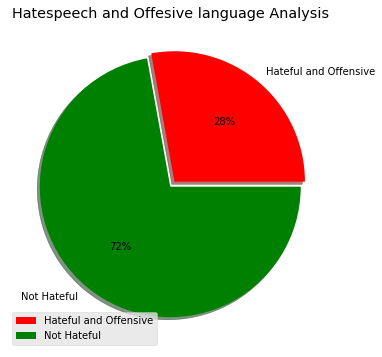

In [356]:
Hate_speech_and_offensive_language_analysis()